# RatGPS2 - plotting

In [ ]:
#!pip install -U gif  
#!pip install "gif[matplotlib]"

In [1]:
#import random
from copy import deepcopy
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import gif
from IPython.display import Image
from matplotlib.patches import Rectangle

pd.set_option('display.max_rows', 100)

path_to_data = "data//"
path_to_NLP = "NLP//"

### Load data:

In [2]:
def read_data(fname):
    with open(fname, "r", encoding="UTF-8") as f:
        data = [line.rstrip().split(' ') for line in f.readlines()]
    df = pd.DataFrame(data = data)
    if len(df.columns) == 2:
        df.columns = ['x', 'y']
        for col in df.columns:
            df[col] = df[col].astype('float32')
    else:
        for col in df.columns:
            df[col] = df[col].astype('int64')        
    return df

In [3]:
#df_feat = read_data("R2192_feat.txt")
#df_pos = read_data("R2192_pos.txt")

df_feat = read_data(path_to_data + "R2192_1x200_at5_step200_bin100-RAW_feat.dat")
df_pos = read_data(path_to_data + "R2192_1x200_at5_step200_bin100-RAW_pos.dat")

In [18]:
df_feat[:5]

0   1   2   3   4   5   6   7   8   9   ...  53  54  55  56  57  58  59  \
0   0   0   0   0   0   0   0   0   0   0  ...   0   0   2   0   0   0   0   
1   0   0   0   0   2   0   0   0   0   0  ...   0   0   1   1   0   0   0   
2   0   0   0   0   9   0   2   0   0   0  ...   0   0   1   4   0   0   0   
3   0   2   0   0   7   0   4   0   0   0  ...   0   0   0   0   0   0   0   
4   0   0   0   0   3   0   4   0   0   0  ...   0   0   2   0   0   0   0   

   60  61  62  
0   0   0   0  
1   0   0   0  
2   0   0   0  
3   0   0   0  
4   0   0   0  

[5 rows x 63 columns]

In [5]:
df_pos[:5]

x          y
0  51.719799  50.123798
1  52.901798  49.870300
2  53.595901  47.411301
3  47.983200  41.520599
4  38.970699  34.953899

Ranges of the coordinates in the 1m x 1m box:

In [4]:
min_x, max_x = np.min(df_pos['x']), np.max(df_pos['x'])
min_y, max_y = np.min(df_pos['y']), np.max(df_pos['y'])

print(min_x, max_x)
print(min_y, max_y)

6.051229953765869 107.04399871826172
4.390329837799072 105.18099975585938


In [41]:
# Rescale - probably not needed, seems that coordinates are already in cm.
#df_pos2 = deepcopy(df_pos)
#df_pos2['x'] = (df_pos['x'] - min_x) / (max_x - min_x)
#df_pos2['y'] = (df_pos['y'] - min_y) / (max_y - min_y)
#df_pos2 [:5]

Identify most important neurons for color coding:
 - Having all neurons color coded would mean having 63 colors, which would be hard to distinguish.
 - Most important neurons are the ones that spike most at any time during the experiment.

In [5]:
totals = df_feat.sum(axis = 0, skipna = True)
print('Number of neurons:', len(totals))
#totals.sort_values(ascending = False)
max_spikes = df_feat.max(axis = 0, skipna = True)
tmp_times_spiked = df_feat>0
times_spiked = tmp_times_spiked.sum(axis = 0)
df_counts = pd.DataFrame(data = [totals, max_spikes, times_spiked]).T
df_counts.columns = ['total spikes', 'max spikes in window', 'times spiked']

Number of neurons: 63


In [8]:
df_counts

total spikes  max spikes in window  times spiked
0            758                     7           487
1           1359                     9           807
2           1310                     5           833
3            576                     9           205
4            876                    11           332
5            208                     6           112
6            561                     8           308
7            199                     6           133
8            736                    10           327
9            163                     5           103
10           185                     3           162
11           199                     8            89
12           156                     8            79
13           701                    10           279
14           147                     5           106
15          1068                     4           925
16           289                     3           277
17          1045                     9           440
18           294                     3           254
19           489                     6           371
20           440                     5           331
21           270                     6           174
22           360                     8           227
23           767                     8           385
24           289                     4           223
25          1144                     8           647
26          1086                    12           333
27           306                     9           150
28           108                     7            58
29           131                     6           102
30           534                     5           340
31           281                     6           199
32           258                    12            96
33            78                     4            46
34           337                    10           126
35           815                    10           328
36           354                     7           194
37           342                     9           128
38           264                     3           201
39           778                    10           376
40           749                     6           508
41           337                    11           157
42           587                    13           188
43           563                    11           202
44           248                     7           148
45           236                     4           215
46           673                     7           486
47           519                     7           214
48            72                     5            42
49          1290                    10           781
50           419                     5           324
51           629                     9           280
52           895                     7           584
53           421                     7           186
54           140                     5            90
55          5624                     8          2914
56           352                     6           219
57           351                     8           161
58           266                     9           128
59           147                     3           137
60           492                     4           336
61           282                     5           180
62           496                     7           278

In [75]:
#timestep = 2
#neuron = 4
#df_feat.iloc[timestep,neuron]

9

It is not really clear which ones we should exclude.

### Centroids

For plotting also centroids of the receptive fields.

In [8]:
df_feat = read_data(path_to_data + "R2192_1x200_at5_step200_bin100-RAW_feat.dat")
df_pos = read_data(path_to_data + "R2192_1x200_at5_step200_bin100-RAW_pos.dat")
df_all = pd.concat([df_feat, df_pos], axis=1)
neurons = df_feat.columns.tolist()
centroids_x= []
centroids_y= []

for neuron in neurons:
    d = df_all[df_all[neuron]>0]
    d = d[[neuron, 'x', 'y']]
    centroids_x.append(np.sum(d[neuron]*d['x'])/np.sum(d[neuron]))
    centroids_y.append(np.sum(d[neuron]*d['y'])/np.sum(d[neuron]))
    
df_centroids = pd.DataFrame(data = [neurons, centroids_x, centroids_y]).T
df_centroids.columns = ['neuron', 'x', 'y']
df_centroids.head()

neuron           x          y
0     0.0   72.447221  54.797742
1     1.0   64.653114  60.338917
2     2.0   55.823571  53.845403
3     3.0  102.899356  64.399738
4     4.0   52.172026  51.534391

### Plots:

In [9]:
# Colors (12):
colors = ["#a6cee3", # light blue]      
          "#a6cee3", # light blue
          "#1f78b4", # blue
          "#b2df8a", # light green
          "#33a02c", # green
          "#fb9a99", # pink
          "#e31a1c", # red
          "#fdbf6f", # light orange
          "#ff7f00", # orange 
          "#cab2d6", # light violet
          "#6a3d9a", # violet
          "#ffff99", # light yellow
          "#b15928"] # brown

In [10]:
def plot_rat(timestep, df_feat, df_pos, neurons, colors):
    # plot previous timesteps:
    if timestep != 0:
        for t in range(timestep-1):
            # movement trajectory:
            x0, y0 = df_pos.iloc[timestep]
            x1, y1 = df_pos.iloc[timestep+1]
            plt.plot(plt.plot([x0, x1], [y0, y1], 'k-', lw=2)) 
            
            #spikes:
            for i in range(len(neurons)):
                neuron = neurons[i]
                spikes = df_feat.iloc[t,neuron]
                plt.Circle((x0, y0), radius=spikes/10, color=colors[i])

    # plot current timestep: 
    for i in range(len(neurons)):
        neuron = neurons[i]
        spikes = df_feat.iloc[timestep,neuron]
        plt.Circle((x0, y0), radius=spikes/10, color=colors[i])   

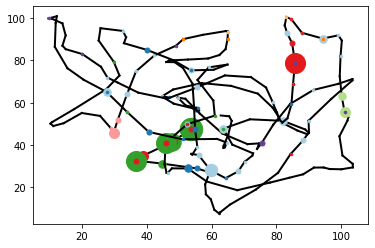

In [11]:
# Spikes of 11 first neurons in 200 first timesteps:

timestep =  200
neurons = df_feat.columns.tolist()[:11]
#plt.plot()
#plt.Rectangle((500, 1500), 1400, 1300, linewidth=1, edgecolor='r', facecolor="none")
#fig = plt.figure()

# plot previous timesteps:
if timestep != 0:
    for t in range(timestep-1):
        # movement trajectory:
        x0, y0 = df_pos.iloc[t]
        x1, y1 = df_pos.iloc[t+1]
        plt.plot([x0, x1], [y0, y1], 'k-', lw=2)

        #spikes:
        for i in range(len(neurons)):
            neuron = neurons[i]
            spikes = df_feat.iloc[t,neuron]
            if spikes!=0:
                plt.plot([x0], [y0], 'g.', markersize=spikes*5, color=colors[i])
                #plt.Circle((x0, y0), radius=spikes, color=colors[i])

# plot current timestep: 
for i in range(len(neurons)):
    neuron = neurons[i]
    spikes = df_feat.iloc[timestep,neuron]
    plt.plot([x0], [y0], 'g.', markersize=spikes*5)
    #plt.Circle((x0, y0), radius=spikes*10, color=colors[i])  

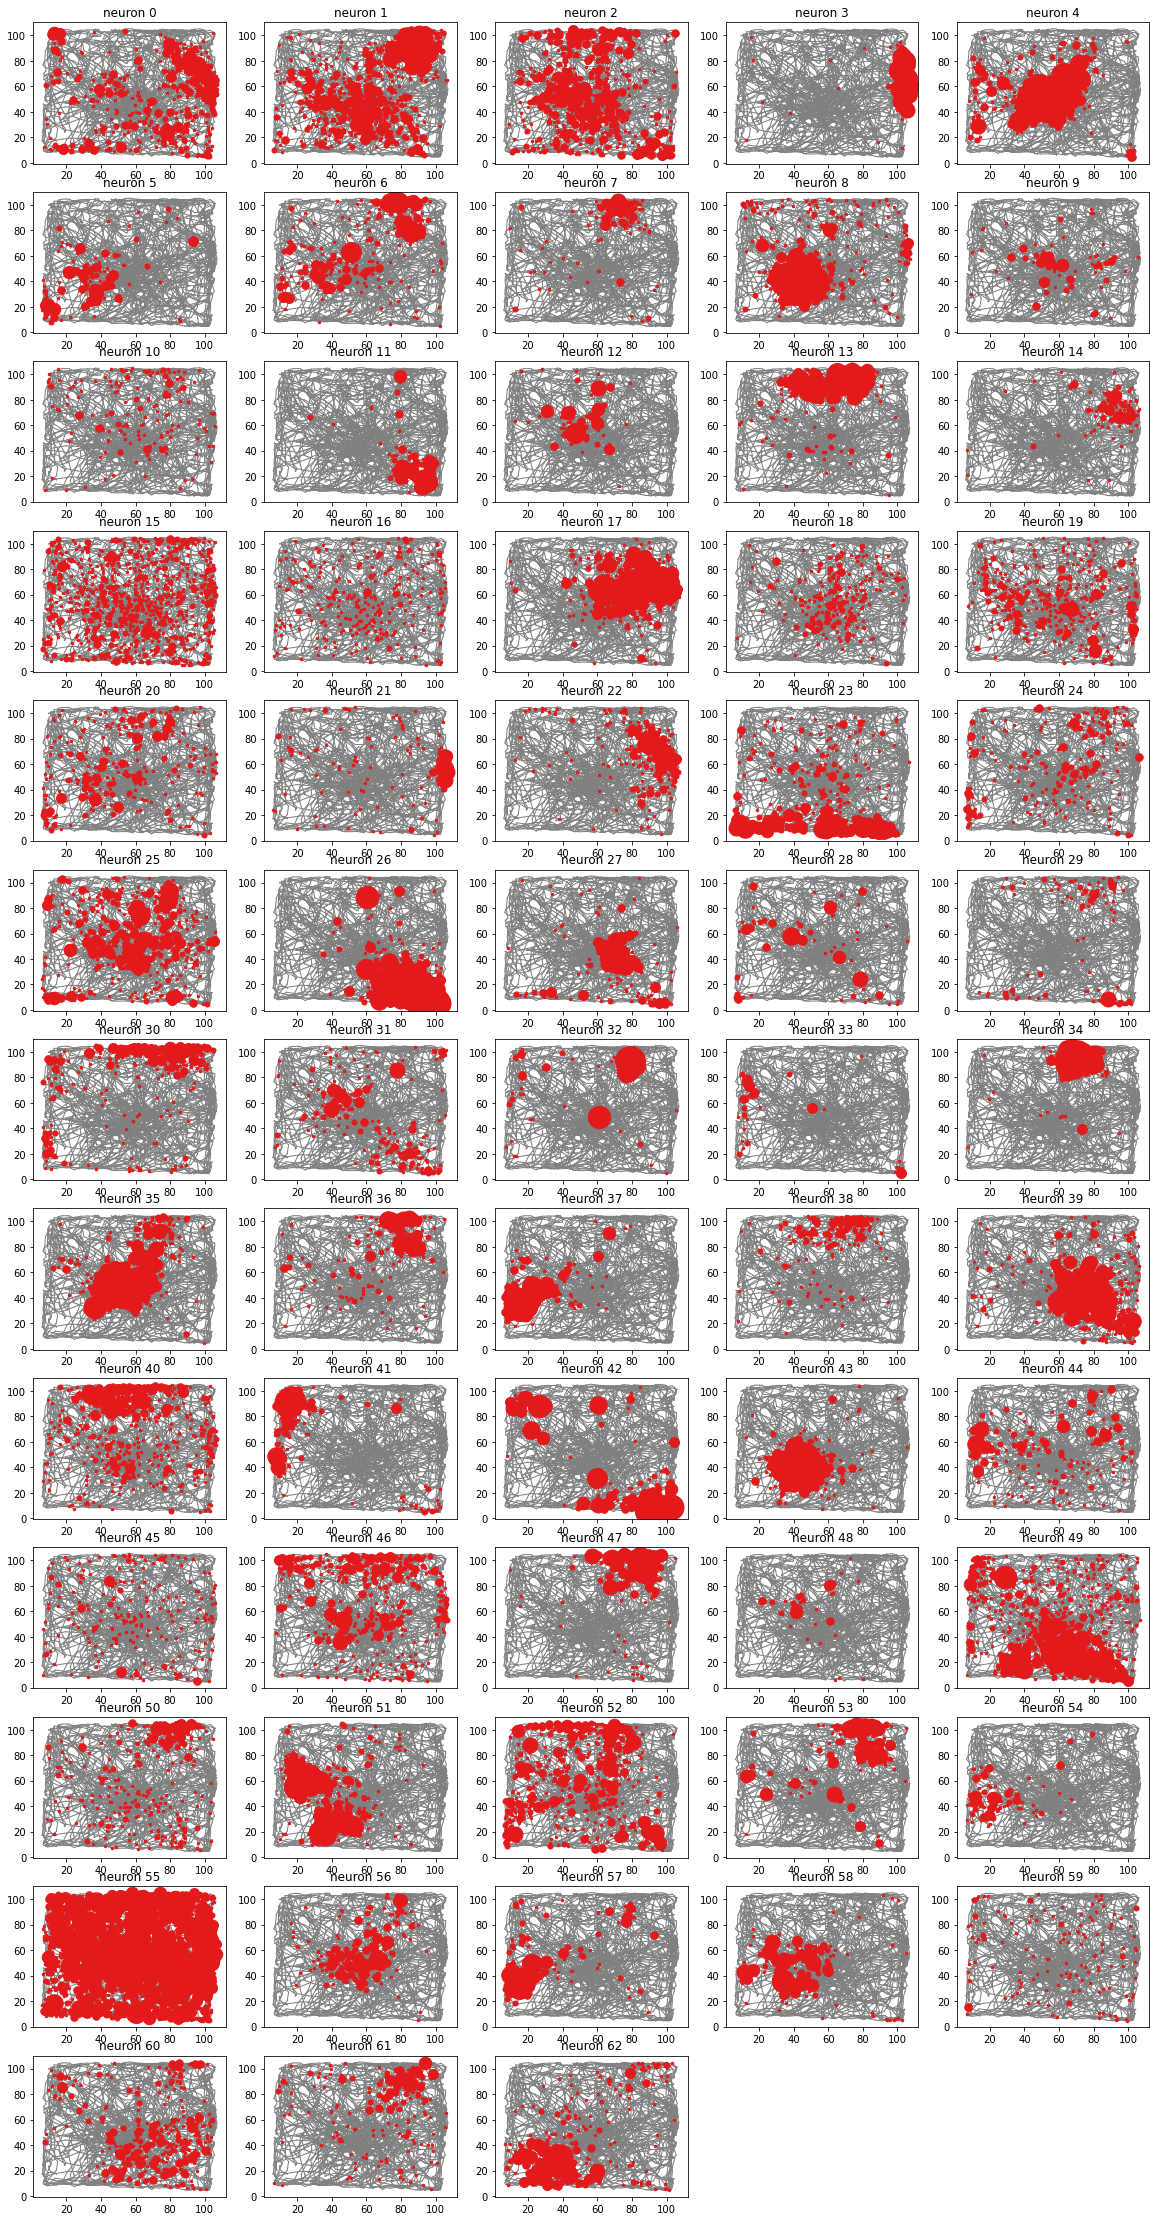

In [131]:
# Spikes of all neurons in all timesteps:

plt.rcParams['figure.figsize'] = (20.0, 40.0)
timestep = len(df_pos) # 200 
neurons = df_feat.columns.tolist() #[:12]
rows, cols = 13, 5

for i in range(len(neurons)):
    plt.subplot(rows, cols, i+1)
    plt.title("neuron " + str(i))
    neuron = neurons[i]
    
    # plot lines:
    for t in range(timestep-1):
        # movement trajectory:
        x0, y0 = df_pos.iloc[t]
        x1, y1 = df_pos.iloc[t+1]
        plt.plot([x0, x1], [y0, y1], '-', lw=1, color ='gray') # 'k-',

    #plot spikes:
    for t in range(timestep):
        spikes = df_feat.iloc[t, neuron]
        if spikes!=0:
            x0, y0 = df_pos.iloc[t]
            plt.plot([x0], [y0], 'g.', markersize=spikes*5, color="#e31a1c")  # color=colors[i]
            #plt.Circle((x0, y0), radius=spikes, color=colors[i])

    ## plot current timestep: 
    #spikes = df_feat.iloc[timestep,neuron]
    #plt.plot([x0], [y0], 'g.', markersize=spikes*5)

In [ ]:
# TODO: plt.savefig() ... (check)

## Plotting also centroids 

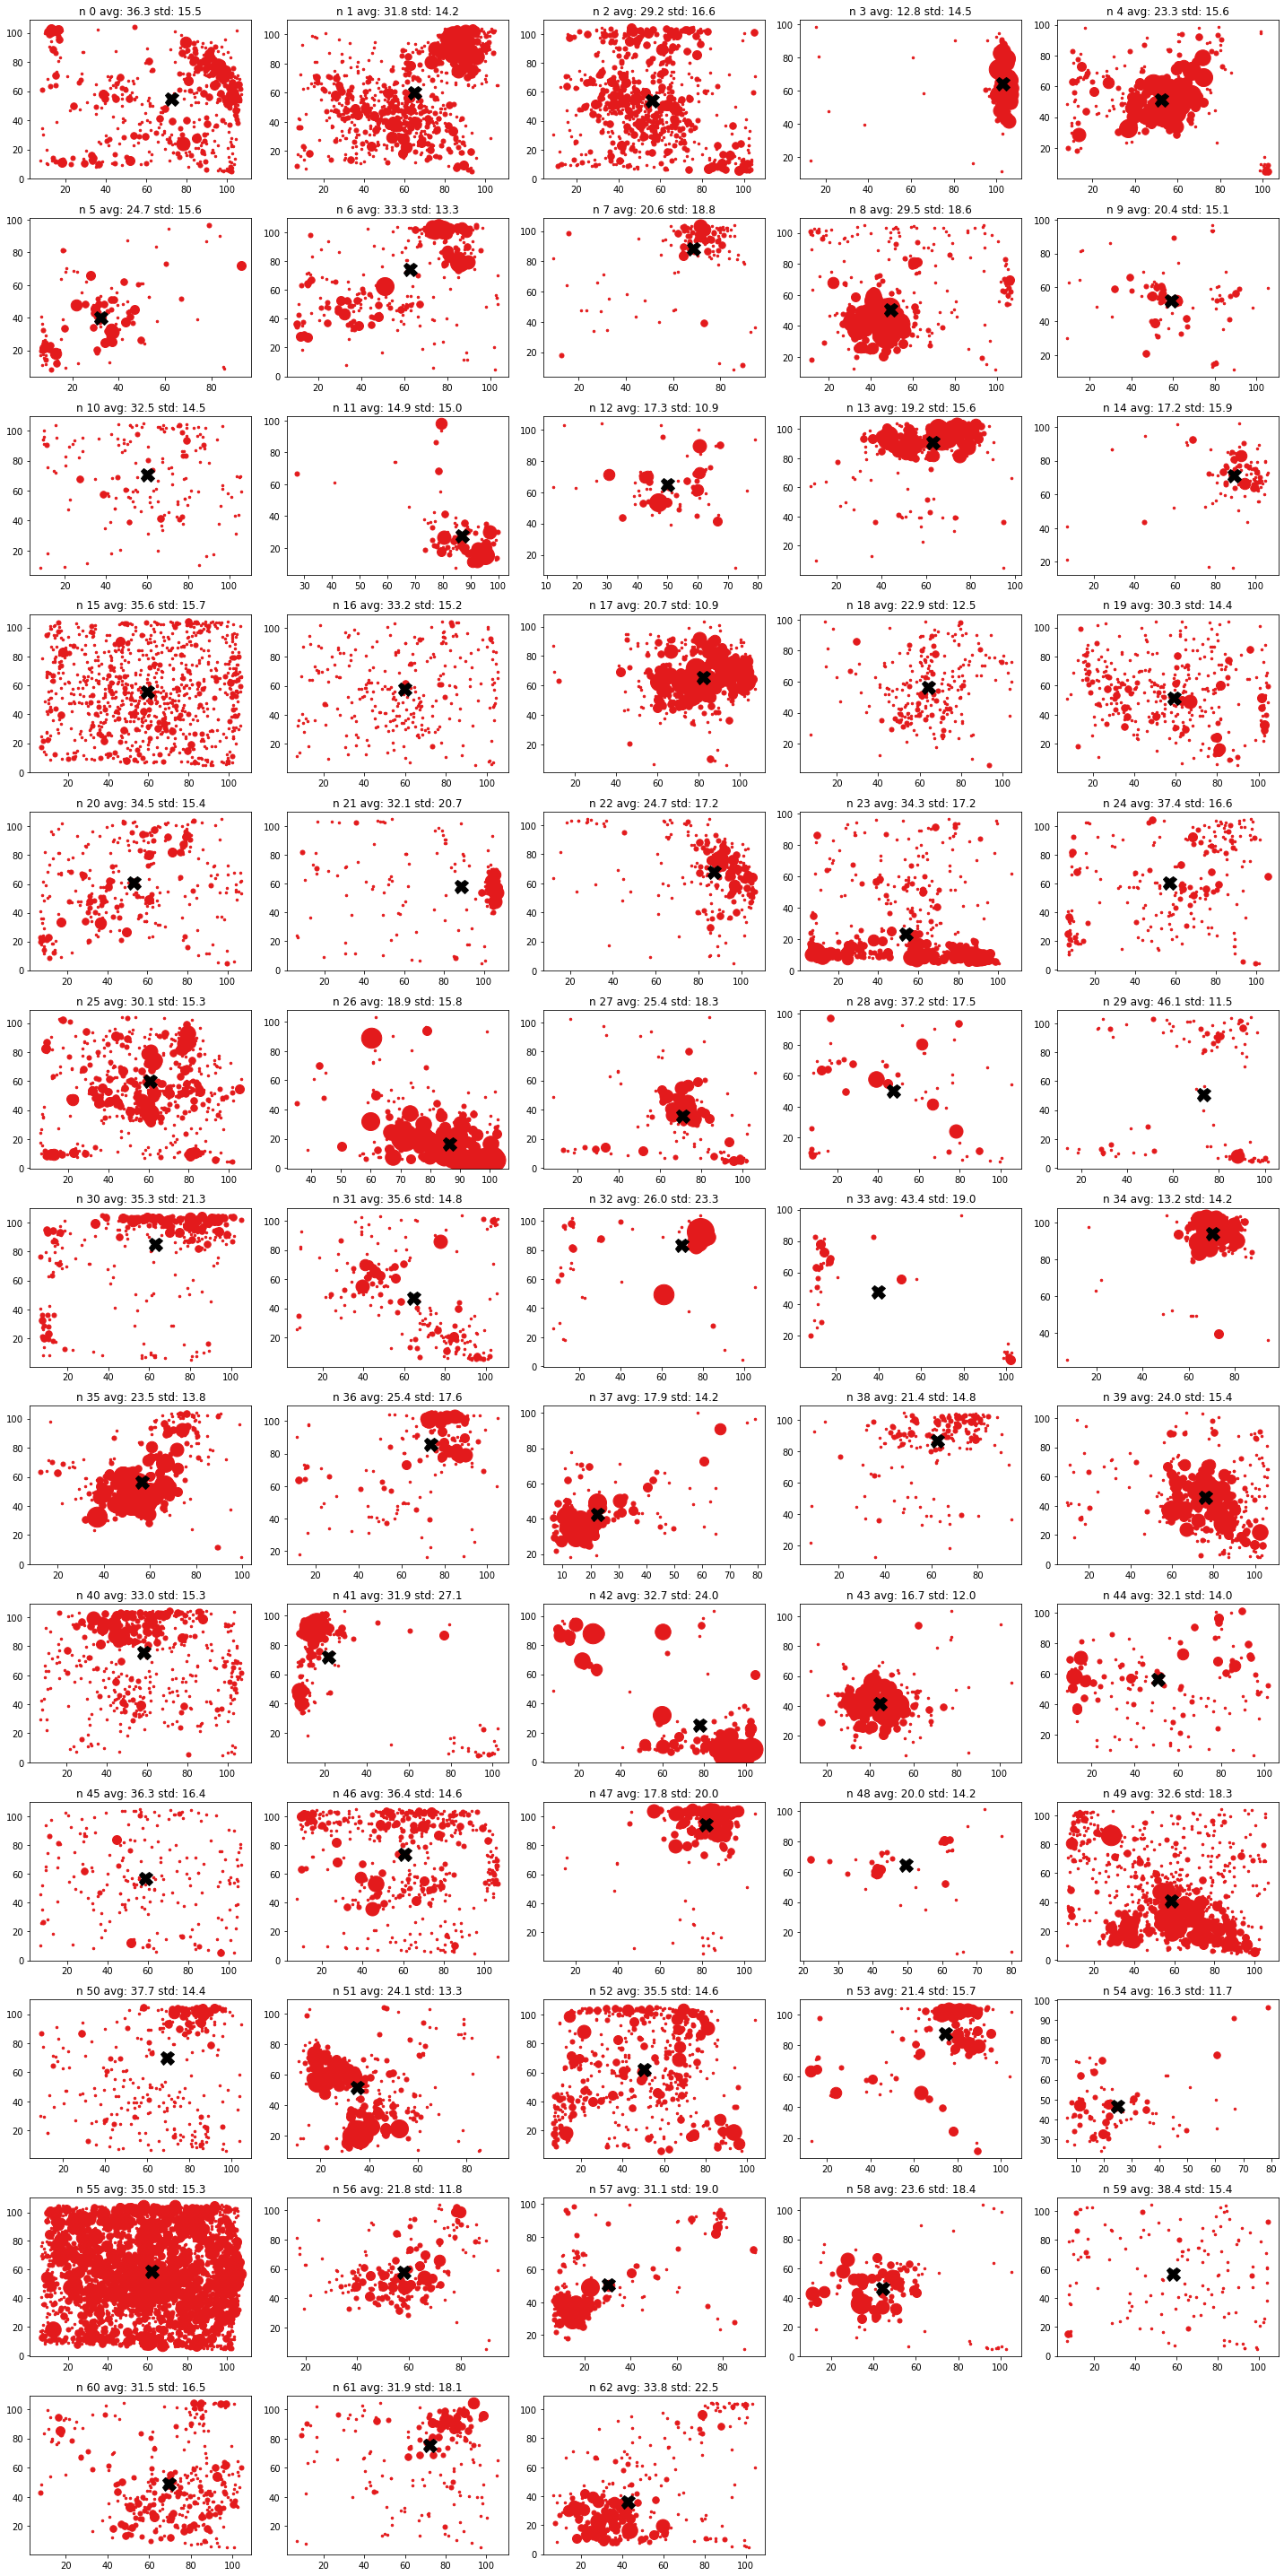

In [28]:
# Spikes of all neurons in all timesteps:

plt.rcParams['figure.figsize'] = (20.0, 40.0)
timestep = len(df_pos) # 200 
neurons = df_feat.columns.tolist() #[:12]
rows, cols = 13, 5

for i in range(len(neurons)):
    plt.subplot(rows, cols, i+1)
    #plt.title("neuron " + str(i))
    neuron = neurons[i]
    
#    # plot lines:
#    for t in range(timestep-1):
#        # movement trajectory:
#        x0, y0 = df_pos.iloc[t]
#        x1, y1 = df_pos.iloc[t+1]
#        plt.plot([x0, x1], [y0, y1], '-', lw=1, color ='gray') # 'k-',

    #plot spikes:
    for t in range(timestep):
        spikes = df_feat.iloc[t, neuron]
        if spikes!=0:
            x0, y0 = df_pos.iloc[t]
            plt.plot([x0], [y0], 'g.', markersize=spikes*5, color="#e31a1c")  # color=colors[i]
            #plt.Circle((x0, y0), radius=spikes, color=colors[i])
            
    # Plot centroids:
    centroid_x = df_centroids.iloc[neuron]['x']
    centroid_y = df_centroids.iloc[neuron]['y']
    plt.plot([centroid_x], [centroid_y], marker='X', markersize=15, color="black")
    
    # Add mean and st.deviation to title:
    d = df_all[df_all[neuron]>0]
    d = d[[neuron, 'x', 'y']]
    centroid = df_centroids.iloc[neuron]
    dists = np.sqrt((d['x']-centroid['x'])**2+(d['y']-centroid['y'])**2)
    avg = np.mean(dists)
    stdev = np.std(dists)
    plt.title("n " + str(i) + " avg: "+ str(round(avg, 1)) + " std: " +str(round(stdev, 1)))
    plt.tight_layout()   

    ## plot current timestep: 
    #spikes = df_feat.iloc[timestep,neuron]
    #plt.plot([x0], [y0], 'g.', markersize=spikes*5)

# Save:
plt.savefig('centroids.png')

In [10]:
#df_centroids.iloc[2]

neuron     2.000000
x         55.823571
y         53.845403
Name: 2, dtype: float64

### Histograms of distances to cluster centre

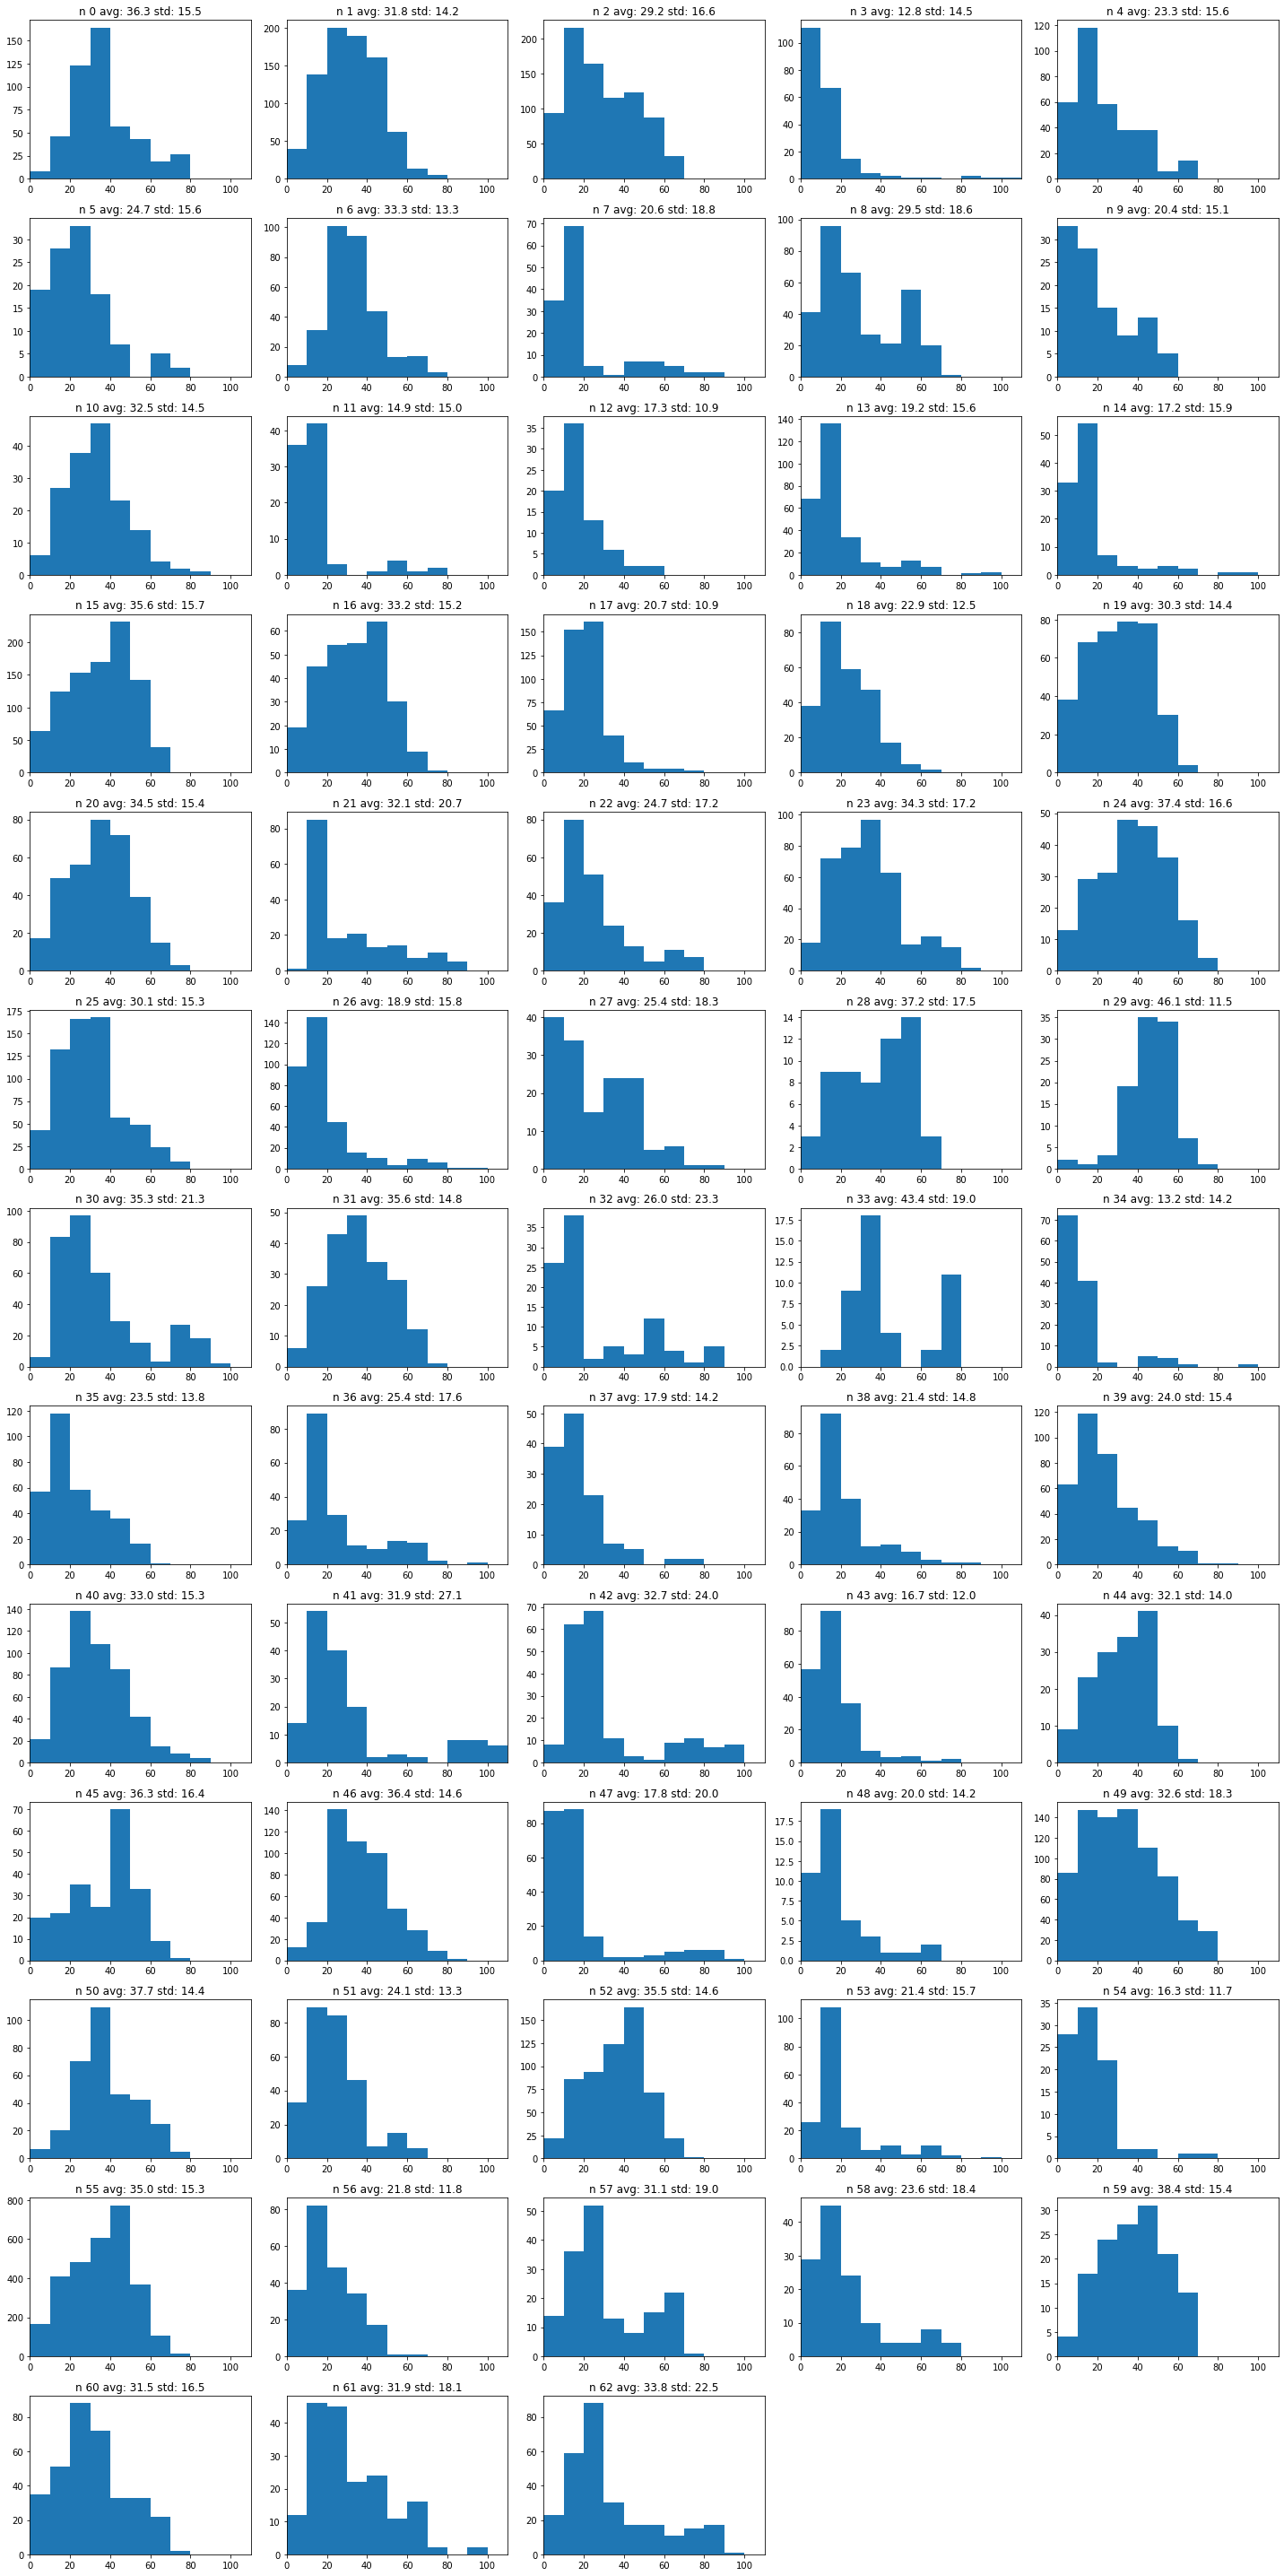

In [27]:
plt.rcParams['figure.figsize'] = (20.0, 40.0)
timestep = len(df_pos) # 200 
neurons = df_feat.columns.tolist() #[:12]
rows, cols = 13, 5

means = []
st_devs = []

for i in range(len(neurons)):
    plt.subplot(rows, cols, i+1)
    #plt.title("neuron " + str(i))
    neuron = neurons[i]
    
    # Plot histograms:
    d = df_all[df_all[neuron]>0]
    d = d[[neuron, 'x', 'y']]
    centroid = df_centroids.iloc[neuron]
    dists = np.sqrt((d['x']-centroid['x'])**2+(d['y']-centroid['y'])**2)
    avg = np.mean(dists)
    stdev = np.std(dists)
    means.append(avg)
    st_devs.append(stdev)
    plt.hist(dists, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
    plt.xlim(0,110)
    #plt.annotate(text = 'mean', xy=(610, 20.525), 
    #         color = '#41ab5d', fontsize=18, weight='bold')
    # d.columns = ['neuron', 'x', 'y']
    # d = d.merge(d, df_centroids)
    
    plt.title("n " + str(i) + " avg: "+ str(round(avg, 1)) + " std: " +str(round(stdev, 1)))
    plt.tight_layout()            
    ## plot current timestep: 
    #spikes = df_feat.iloc[timestep,neuron]
    #plt.plot([x0], [y0], 'g.', markersize=spikes*5)

# Save:
plt.savefig('histgrams_dist_to_centroid.png')

In [ ]:
means = []
st_devs = []

## Animation:

In [ ]:
# vt LAB_3_4_Unsupervisedlearning

#frames = []
#neurons = [:11]

#for timestep in range(len(df_feat)):
#    frame = plot_rat(timestep, df_feat, df_pos, neurons)
#    frames.append(frame)
#
#gif.save(frames, 'noisy.gif', duration=3.5, unit="s", between="startend")    

## Plotting most similar neurons:

In [12]:
# Most similar obtained from first_trial.py.
similar_df=  pd.read_csv(path_to_NLP + "most_similar.csv", encoding = "UTF-8")
similar_df.columns = [x for x in range(63)]
similar_df = similar_df[:3]
similar_df

0   1   2   3   4   5   6   7   8   9   ...  53  54  55  56  57  58  59  \
0  22  50  12  21  35  20  36  34  43  28  ...  36  37  15  35  37  43  60   
1  14  47   _  22  56  51  53  38  48  12  ...   6  57  46   4  54  44  23   
2  28  61   4  14  33  48  35  13  51  48  ...  22  52  39   6  32   8  45   

   60  61  62  
0  59  47  23  
1  61   1  37  
2  55  50  16  

[3 rows x 63 columns]

In [ ]:
# plot lines:
#def make_lines(df_pos):
#    timestep = len(df_pos) 
#    fig = plt.figure()
#    for t in range(timestep-1):
#        # movement trajectory:
#        x0, y0 = df_pos.iloc[t]
#        x1, y1 = df_pos.iloc[t+1]
#        plt.plot([x0, x1], [y0, y1], '-', lw=1, color ='gray') # 'k-',
#    return fig
#
#lines_plot = make_lines(df_pos) 

In [13]:
# Plot: first plot is of the neuron itself, and the other 5 are most similar neurons:

def plot_most_similar(neuron, similar_df): # , lines_plot
    timestep = len(df_pos) # len(df_pos) # 200
    plt.rcParams['figure.figsize'] = (15.0, 2.0) 
    neurons = [neuron]+ similar_df[neuron].tolist() #[:12]
    rows, cols = 1, 6
    j= 0
    
    for i in range(len(neurons)):
        if neuron!="_":
            plt.subplot(rows, cols, j+1)
            neuron = neurons[i]
            if i==0:
                plt.title("neuron " + str(neuron))
            else:
                plt.title("SIM " + str(i) + ": neuron " + str(neuron))
            j+=1

            ## plot lines:
            #for t in range(timestep-1):
            #    # movement trajectory:
            #    x0, y0 = df_pos.iloc[t]
            #    x1, y1 = df_pos.iloc[t+1]
            #    plt.plot([x0, x1], [y0, y1], '-', lw=1, color ='gray') # 'k-',

            #plot spikes:
            for t in range(timestep):
                spikes = df_feat.iloc[t, neuron]
                if spikes!=0:
                    x0, y0 = df_pos.iloc[t]
                    plt.plot([x0], [y0], 'g.', markersize=spikes*5, color="#e31a1c")  # color=colors[i]
                    #plt.Circle((x0, y0), radius=spikes, color=colors[i])
        


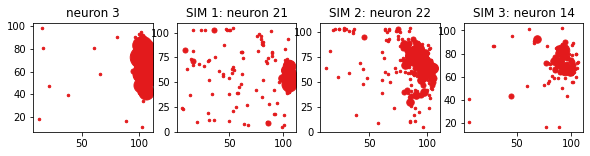

In [78]:
plot_most_similar(3, similar_df)

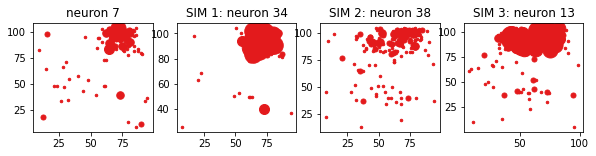

In [95]:
plot_most_similar(7, similar_df)

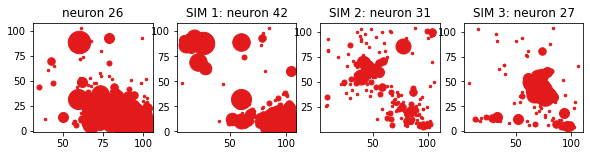

In [80]:
plot_most_similar(26, similar_df)

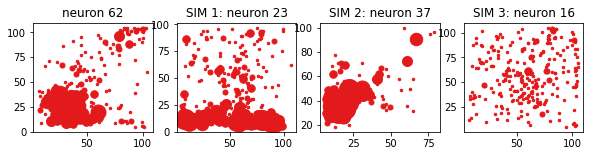

In [92]:
plot_most_similar(62, similar_df)

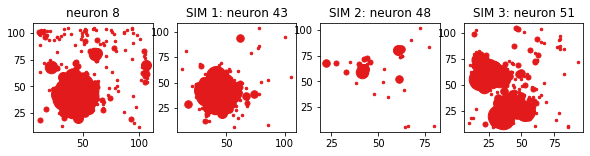

In [97]:
plot_most_similar(8, similar_df)

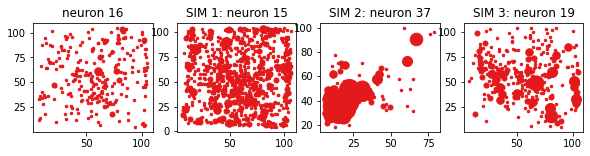

In [98]:
plot_most_similar(16, similar_df)

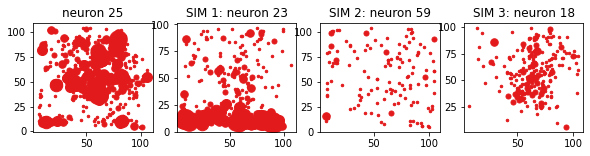

In [99]:
plot_most_similar(25, similar_df)